# Vector Space Model


Vector Space Model es un modelo que representa un documento como un vector de términos, donde cada término es una dimensión del vector.

- Documentos con diferentes palabras y largos viven en el mismo espacio.
- Estas representaciones son además llamadas **Bag of Words** (o bolsa de palabras), donde un documento es representado por un conjunto no ordenado de sus términos.

- El valor en cada dimensión is un peso que presenta la relevancia del término $i$ del vocabulario $V$ en el documento $d$.

\begin{equation*}
d^{\rightarrow} = (w_{1}, \ldots, w_{|V|} )
\end{equation*}

- Bag-of-words no representa la semántica de los documentos, palabras que son sinónimos por ejemplo son consideradas como términos diferentes, además el orden de las palabras dentro del documento se pierde.


**Term Frequency (TF)**: También llamada Count Vector, el peso asociado a cada término del vocabulario dentro de un documento viene dado por la frecuencia del término dentro del documento ($tf_{i}$). 



**Term Frequency-Inverted Document Frequency (TF-IDF)**: Esta transformación consiste en normalizar la frecuencia de cada término  $tf_{i}$ de un documento por $idf_{i} = log(\frac{N}{n_{i}})$, donde $n_{i}$ es las veces que el término ha aparecido al menos una vez en el total de documentos y $N$ es el número de documentos, siendo el peso para el término $i$ el siguiente $w_{i}= tf_{i} \times idf_{i}$.


<img src='img/bow_example.jpg'>

Notar que si existe un término $j$ que aparece en todos los documentos su peso es 0 pues $idf_{j}=log(\frac{N}{n_{j}})=log(\frac{N}{N}) = log(1)=0$.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import re

#Preprocesamiento
import spacy
from spacy.lang.es.stop_words import STOP_WORDS #importar set de stopwords
from nltk.stem import SnowballStemmer #importar stemmer
nlp = spacy.load('es_core_news_sm') #python -m spacy download es

#Bag-of-words
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfVectorizer

#Clasificación
import pickle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, classification_report

## 1. Preprocesamiento


El objetivo del preprocesamiento en text-mining es reducir el vocabulario, eliminando aquellas palabras irrelevantes y homologando palabras con un significado similar.
 
 Algunas técnicas que podemos aplicar para reducir el vocabulario:
 1. **Stop-words**: palabras que aportan poca información, por ejemplo: artículos, preposiciones, conectores. 
 2. **Stemming**: Llevar las palabra a su raíz gramatical. 
 3. **Lemmatization**: Llevar las palabras a su lema. 
 4. **Filtrar palabras de baja frecuencia**, por ejemplo menor a 10.
 5. **Filtrar palabras con alta frecuencia** (stopwords contextuales), por ejemplo aquellas palabras que aparecen en todos los documento. En este caso una transformación TF-IDF genera una columna de ceros, esto implica nula o poca heterogeneidad por ende eliminar.
 6. **Part of Speech Tagging (POST)**: etiquetado gramatical. Se suele utilizar en selección de atributos, por ejemplo dejando solo los sustantivos, pues estos son los que tienen la mayor parte de la información en una oración.
 7. Usar **técnicas de selección de atributos**, por ejemplo, mutual information, chi-square, etc.
 
 
 Buenas prácticas de procesamiento:

1. Eliminar caracteres no alfa-numéricos: @\_\#\%\$/(?
2. Corrección de Ortografía. Las palabras con mala ortografía suelen tener baja frecuencia.
3. Eliminar números, urls, correos (depende del contexto).
4. Identificar palabras claves de ser necesario, por ejemplo, "Juegos Olímpicos" debiese ser considerado como un token.

### Base de datos
La base de datos consiste de 5 conjuntos de noticias extraídas de la radio biobio. 
Cada conjunto de noticias contiene 200 documentos (noticias) y tiene asociado una categoría en {nacional, internacional, economía, sociedad, opinion}.

**Creditos**: 

- Pablo Badilla Torrealba 
- https://github.com/dccuchile/CC6205/tree/master/tutorials

In [3]:
df = pd.read_csv('news_biobio.csv', index_col=0)

In [1]:
def tokenizer(doc, sep=None, stopwords_remove =False, lemmatization=False, stemming = False, vocabulary=None):
    '''
    Por defecto divide la sentencia por el carácter espacio.
    Ej: 'Data Mining is the best course'->['Data',  'Mining', 'is', 'the', 'best', 'course']
    
    Input: 
    1. doc: str, documento.
    2. sep: str, carácter para dividir el documento en tokens, por defecto es el espacio.
    3. stopwords_remove: bool, si es True remueve los stopwords del documento.
    4. lemmatization: bool, si es True lleva las palabras a su lema.
    5. stemming: bool, si es True lleva las palabas a su raíz.
    6. vocabuary: list, si un vocabulario es dado filtra las palabras que no estan presentes en el.
    
    Output: 
    list, lista de tokens.
    
    '''
    
    doc = re.sub(r'[^\w\s]','', doc) #elimina los símbolos de puntuación excepto underscore
    doc = re.sub(r'[a-zA-Z]+[0-9]+', '', doc) #elimina los caracteres que contienen letras y números
    doc = re.sub(r'[0-9]+', ' ', doc) #elimina los caracteres numéricos
   
    tokens = doc.split(sep) #tokenización
    tokens = [word.lower() for word in tokens] #pasar todas las palabras a minúsculas
    
    
    
    if stopwords_remove ==True: #remover stopwords y palabras con menos de tres caracteres
        tokens = [word for word in tokens if word not in STOP_WORDS and len(word)>2]
    
    if lemmatization==True:
        tokens = [nlp(word)[0].lemma_ for word in tokens]
        
    if stemming == True:
        stemmer = SnowballStemmer('spanish')
        tokens = [stemmer.stem(word) for word in tokens]
    
    if vocabulary is not None:
        tokens = [word for word in tokens if word in vocabulary]
    
    return tokens


In [5]:
text = df['title'].iloc[2]
print('Texto original:\n', text, '\n')
print('Texto tokenizado:\n', tokenizer(text), '\n')
print('Texto tokenizado sin stopwords:\n', tokenizer(text, stopwords_remove=True), '\n')
print('Texto tokenizado con lematización:\n', tokenizer(text, lemmatization=True), '\n')
print('Texto tokenizado con stemming:\n', tokenizer(text, stemming=True), '\n')

Texto original:
 Habla director de Compin Bío Bío que se autoaprobó licencia: afirma que no se percató que era suya 

Texto tokenizado:
 ['habla', 'director', 'de', 'compin', 'bío', 'bío', 'que', 'se', 'autoaprobó', 'licencia', 'afirma', 'que', 'no', 'se', 'percató', 'que', 'era', 'suya'] 

Texto tokenizado sin stopwords:
 ['director', 'compin', 'bío', 'bío', 'autoaprobó', 'licencia', 'afirma', 'percató'] 

Texto tokenizado con lematización:
 ['hablar', 'director', 'de', 'compin', 'bío', 'bío', 'que', 'se', 'autoaprobó', 'licenciar', 'afirmar', 'que', 'no', 'se', 'percatar', 'que', 'ser', 'suyo'] 

Texto tokenizado con stemming:
 ['habl', 'director', 'de', 'compin', 'bio', 'bio', 'que', 'se', 'autoaprob', 'licenci', 'afirm', 'que', 'no', 'se', 'percat', 'que', 'era', 'suy'] 



In [6]:
#Creamos los objetos que permiten llevar el corpus a un modelo bag-of-words
tf_vectorizer = CountVectorizer(analyzer='word', tokenizer=tokenizer)
tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tokenizer)

# Extraemos 5 noticias y se la entregamos al vectorizador para que las transforme a vectores BoW.
tf_sample = tf_vectorizer.fit_transform(df.sample(5, random_state=0).title)
tfidf_sample = tfidf_vectorizer.fit_transform(df.sample(5, random_state=0).title)

# Python guarda la matriz en un matriz de tipo sparse, debido a que existen varios palabras con ocurrencia 0
tf_sample 

<5x63 sparse matrix of type '<class 'numpy.int64'>'
	with 74 stored elements in Compressed Sparse Row format>

In [7]:
#visualización de la matriz tf
tf_sample = pd.DataFrame(tf_sample.todense(), columns=tf_vectorizer.get_feature_names()) 
tf_sample

,a,al,allamand,alza,avión,bungee,candidaturas,cayó,caída,cortarse,...,su,superintendente,susto,tempore,transparencia,tras,un,vida,vivió,y
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,0,1,...,1,0,1,0,0,1,1,1,1,0


In [8]:
#visualización de la matriz tf-idf
tfidf_sample = pd.DataFrame(tfidf_sample.todense(), columns=tfidf_vectorizer.get_feature_names()) 
tfidf_sample

,a,al,allamand,alza,avión,bungee,candidaturas,cayó,caída,cortarse,...,su,superintendente,susto,tempore,transparencia,tras,un,vida,vivió,y
0,0.000000,0.000000,0.000000,0.281066,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.281066,0.000000,0.000000,0.281066,0.000000,0.000000,0.000000,0.000000,0.188233
1,0.209893,0.000000,0.260157,0.000000,0.000000,0.000000,0.260157,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.174230
2,0.000000,0.319846,0.000000,0.000000,0.319846,0.000000,0.000000,0.000000,0.319846,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214205
3,0.233121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.288947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.243193,0.000000,0.243193,0.000000,0.243193,...,0.243193,0.000000,0.243193,0.000000,0.000000,0.243193,0.243193,0.243193,0.243193,0.000000


## 2. Clasificación

In [9]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, decimals=3)

        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
#Definimos el conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(df.content, df.category, test_size=0.2, random_state=0, stratify= df.category)

In [11]:
#Creamos objetos para llevar el corpus a bag-of-words
args = {"stopwords_remove": True, 'stemming': True}
tf_vectorizer = CountVectorizer(analyzer='word', tokenizer=lambda text: tokenizer(text, **args),
                               max_df = 0.8, min_df = 5)
tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=lambda text: tokenizer(text, **args),
                                  max_df = 0.8, min_df = 5) 

El código anterior realizará el siguiente procesamiento al corpus:
1. Elimina stopwords.
2. Aplica stemming.
3. Elimina palabras que aparacen en más del 80% de los documentos.
4. Elimina palabras que aparecen en menos de 5 documentos.

### 2.1 Naive bayes

Sea nuestro conjunto de datos representado por $\{x_{i}, y_{i}\}_{i=1}^{N}$, donde $x_{i}$ son los features de la observación $i$ e $y_{i}$ su clase, en un clasificador bayesiano la probabilidad de que una observación con vector de features $x$ sea de la clase $c \in \{1, \ldots, C\}$  viene dado por:

\begin{equation*}
P(y=c|x) = \frac{P(x|y=c)P(y=c)}{P(x)} 
\end{equation*}

donde $P(x|y=c) = P(x^{1}, \ldots, x^{|V|}|y=c)$ es la verosimilitud (likelihood), $P(y=c)$ es la probabilidad a priori de la clase $c$ (prior) y $P(y=c|x)$ la probabilidad a posteriori (posterior), luego la clase de una observación sería aquella que máximiza $P(y=c|x)$.

En palabras más simples el modelo bayesiano dice que la probabilidad de que una observación sea de la clase dado sus features es igual al producto entre la probabilidad de observar esos features dado la clase y la probabilidad de observar la clase divida por la probabilidad de observar dichos features.

Naive Bayes para facilitar el cálculo de la expresión anterior asume independencia condicional, es decir, 

\begin{equation*}
P(x^{1}, \ldots, x^{|V|}|y=c) = \prod_{i=1}^{|V|}P(x^{i}|y=c)
\end{equation*}

Las probabilidades anteriores para un modelo bag-of-words se estiman simplemente contando casos favorables versus totales en el conjunto de entrenamiento:

\begin{equation*}
\hat{P}(y=c) = \frac{N_{c}}{N}
\end{equation*}

\begin{equation*}
\hat{P}(x^{j}|y=c) = \frac{N_{jc}}{\sum_{i=1}^{|V|}N_{ic}}
\end{equation*}

,donde $N_{c} = \sum_{i}^{N}\mathbb{1}(y_{i}=c)$ y $N_{jc} = \sum_{i=1}^{N}x^{j} \mathbb{1}(y_{i}=c)$.

NB al asumir independencia condicional la verosimilitud se descompone en un producto de cosas, entonces, a la hora de realizar predicciones sobre un documento, si este documento cuenta con una palabra que no se observa en los documentos de una clase se tendría que $\hat{P}(x^{j}|y=c) =0$, así $\hat{P}(x|y=c)=0$ y por tanto $\hat{P}(y=c|x)=0$ subestimandose la probabilidad de que el documento pertenezca a una clase solo por la no ocurrencia de una palabra.

Para evitar lo anterior se introduce un hiperparámetro conocido como  Laplace smoothing, 

\begin{equation*}
\hat{P}(x^{j}|y=c) = \frac{N_{jc}+\alpha}{(\sum_{i=1}^{|V|}N_{ic})+\alpha|V|}
\end{equation*}

, donde usualmente $\alpha = 1$.

In [12]:
clf_nb = MultinomialNB() #objeto clasificador
tf_clf_nb = Pipeline([('vect', tf_vectorizer), ('clf', clf_nb)])#objeto pipeline

In [13]:
tf_clf_nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.8,
                                 max_features=None, min_df=5,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function <lambda> at 0x000001EFB6667E18>,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [14]:
print('Tamaño del vocabulario:', len(tf_clf_nb['vect'].vocabulary_))

Tamaño del vocabulario: 3511


               precision    recall  f1-score   support

     Economia       0.86      0.95      0.90        40
Internacional       0.92      0.82      0.87        40
     Nacional       0.84      0.93      0.88        40
      Opinion       0.91      0.78      0.84        40
     Sociedad       0.90      0.95      0.93        40

     accuracy                           0.89       200
    macro avg       0.89      0.89      0.88       200
 weighted avg       0.89      0.89      0.88       200

f1-score 0.883760488895277 

Normalized confusion matrix


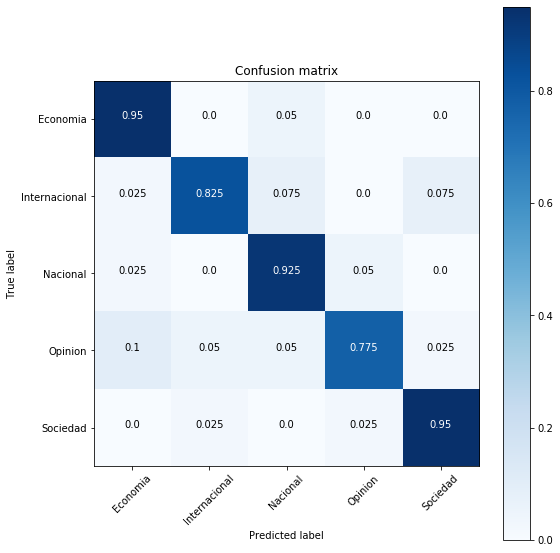

In [15]:
y_predicted = tf_clf_nb.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)
class_report = classification_report(y_test, y_predicted) 
print(class_report)
f1 = f1_score(y_test, y_predicted, average='macro') 
print('f1-score', f1, '\n')
plot_confusion_matrix(cm, [*clf_nb.classes_], normalize=True) 

#### Ejemplo de como guardar un modelo

In [16]:
#Guardar vocabulario
pickle.dump(tf_clf_nb['vect'].vocabulary_, open("vocabulary.pkl","wb"))

#Cargar vocabulario
vocabulary = pickle.load(open("vocabulary.pkl", "rb"))

loaded_vec = CountVectorizer(analyzer='word', tokenizer=lambda text: tokenizer(text, **args),
                             decode_error="replace", vocabulary=vocabulary)
   
#Guardar clasificador
with open('nb_model.pkl', 'wb') as f:
    pickle.dump(tf_clf_nb['clf'], f)

#Cargar clasficador
with open('nb_model.pkl', 'rb') as f:
    clf_nb = pickle.load(f)

In [17]:
[df['title'][1], df['category'][1]]

['Alrededor de 40 mil hogares de Puente Alto, Pirque y San José de Maipo sufren corte de energía',
 'Nacional']

In [18]:
#Realizar una prediccioón
clf_nb.predict(loaded_vec.fit_transform(['Alrededor de 40 mil hogares de Puente Alto, Pirque y San José de Maipo sufren corte de energía']))

array(['Nacional'], dtype='<U13')

### 2.2 Regresión logística



La regresión logística es un modelo discriminativo en vez de generativo a diferencia de Naive Bayes el cual descompone la probabilidad posterior usanto la regla de Bayes, por otro lado, la regresión logística (logit) plantea una solución análitica directa de la probabilidad a posterior.


\begin{equation*}
P(y=c|x, \beta) = \frac{exp(\beta_{c}^{T}x)}{\sum_{c=1}^{C}exp(\beta_{c}^{T}x)}
\end{equation*}

, donde $\beta_{c} = [\beta^{0}_{c}, \beta^{1}_{c}, \ldots, \beta^{|V|}_{c}]$ y $x = [1, x^{1}, \ldots, x^{|V|}]$.

En el caso binario

\begin{equation*}
P(y=1|x, \beta) = \frac{exp(\beta^{T}x)}{1+exp(\beta^{T}x)}, \; P(y=0|x, \beta) = \frac{1}{1+exp(\beta^{T}x)}
\end{equation*}


Los parámetros son aquellos que máximizan la verosimilitud en el conjunto de entrenamiento.

Nota: El logit es un clasificador no lineal, solo es lineal en los parámetros.


<img src='img/logit_2d.png'>

<img src='img/logit_3d.png'>


In [19]:
#Creamos los objetos necesarios para el flujo de entrenamiento
clf_lg = LogisticRegression(multi_class='multinomial', solver='newton-cg') #objeto clasificador
tfidf_clf_lg = Pipeline([('vect', tfidf_vectorizer), ('clf', clf_lg)])

In [20]:
#entrenamiento
tfidf_clf_lg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=5, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                                 tokenizer=<function <lambda> at 0x000001EFB6667EA0>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=Tr

               precision    recall  f1-score   support

     Economia       0.86      0.90      0.88        40
Internacional       0.94      0.80      0.86        40
     Nacional       0.82      0.90      0.86        40
      Opinion       0.89      0.78      0.83        40
     Sociedad       0.84      0.95      0.89        40

     accuracy                           0.86       200
    macro avg       0.87      0.86      0.86       200
 weighted avg       0.87      0.86      0.86       200

f1-score 0.8641681632442035 

Normalized confusion matrix


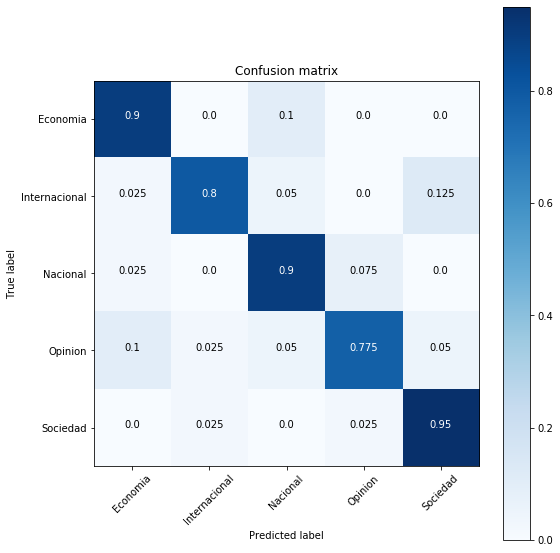

In [21]:
#test
y_predicted = tfidf_clf_lg.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)
class_report = classification_report(y_test, y_predicted) 
print(class_report)
f1 = f1_score(y_test, y_predicted, average='macro') 
print('f1-score', f1, '\n')
plot_confusion_matrix(cm, [*clf_lg.classes_], normalize=True) 

### ¿Cuál sería el performance de los clasificadores si utilizamos como documentos los títulos de la noticia en vez del contenido?

In [22]:
#Definimos el conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(df.title, df.category, test_size=0.2, random_state=0, stratify= df.category)

In [23]:
#Creamos objetos para llevar el corpus a bag-of-words
args = {"stopwords_remove": True, 'stemming': True}
tf_vectorizer = CountVectorizer(analyzer='word', tokenizer=lambda text: tokenizer(text, **args))
tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=lambda text: tokenizer(text, **args)) 

### 1. NB

               precision    recall  f1-score   support

     Economia       0.76      0.80      0.78        40
Internacional       0.73      0.82      0.78        40
     Nacional       0.62      0.80      0.70        40
      Opinion       0.67      0.40      0.50        40
     Sociedad       0.65      0.60      0.62        40

     accuracy                           0.69       200
    macro avg       0.69      0.68      0.68       200
 weighted avg       0.69      0.69      0.68       200

f1-score 0.6751974380806021 

Normalized confusion matrix


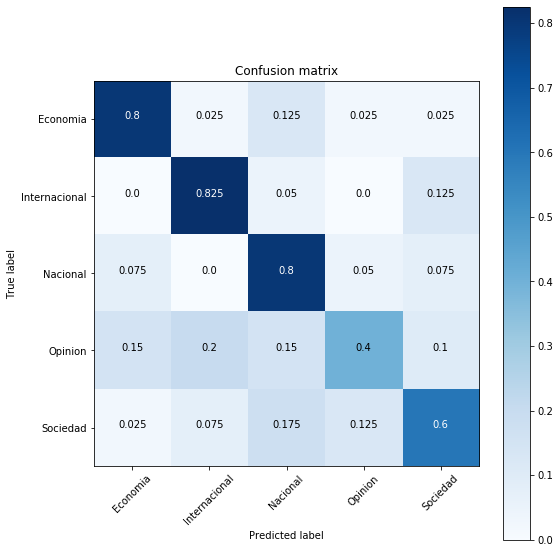

In [24]:
clf_nb = MultinomialNB() #objeto clasificador
tf_clf_nb = Pipeline([('vect', tf_vectorizer), ('clf', clf_nb)])#objeto pipeline
tf_clf_nb.fit(X_train, y_train)
y_predicted = tf_clf_nb.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)
class_report = classification_report(y_test, y_predicted) 
print(class_report)
f1 = f1_score(y_test, y_predicted, average='macro') 
print('f1-score', f1, '\n')
plot_confusion_matrix(cm, [*clf_nb.classes_], normalize=True) 

### 2. LR

               precision    recall  f1-score   support

     Economia       0.82      0.80      0.81        40
Internacional       0.82      0.82      0.82        40
     Nacional       0.60      0.85      0.70        40
      Opinion       0.74      0.50      0.60        40
     Sociedad       0.68      0.62      0.65        40

     accuracy                           0.72       200
    macro avg       0.73      0.72      0.72       200
 weighted avg       0.73      0.72      0.72       200

f1-score 0.7165046169674633 

Normalized confusion matrix


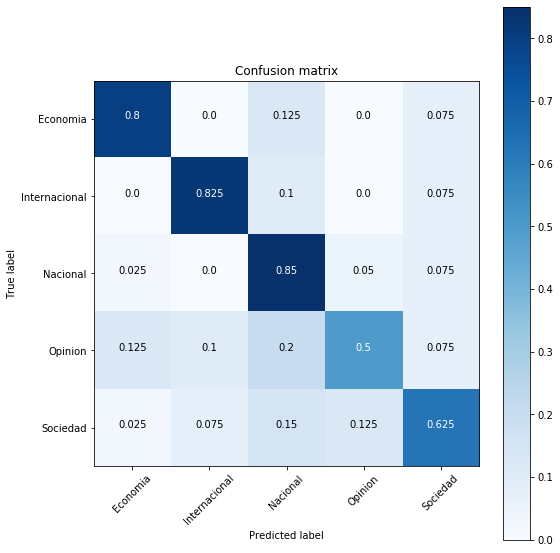

In [25]:
clf_lg = LogisticRegression(multi_class='multinomial', solver='newton-cg') 
tfidf_clf_lg = Pipeline([('vect', tfidf_vectorizer), ('clf', clf_lg)])
tfidf_clf_lg.fit(X_train, y_train)
y_predicted = tfidf_clf_lg.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)
class_report = classification_report(y_test, y_predicted) 
print(class_report)
f1 = f1_score(y_test, y_predicted, average='macro') 
print('f1-score', f1, '\n')
plot_confusion_matrix(cm, [*clf_lg.classes_], normalize=True) 

# Conclusiones

Bag of words es uno de los enfoques más utilizados para representar los documentos como vectores, transformaciones como IDF sobre este modelo pueden ser de bastante utilidad en modelos que son sensibles a la escala de los atributos. Además, vimos un caso aplicado de este método en conjunto a dos clasificadores probabilísticos simples que obtuvieron excelentes resultados categorizando noticias.